In [1]:
import numpy as np
import pylab as plt
import seaborn as sns
from scipy import optimize
import matplotlib
import pickle
from numerics import find_coefficients_Huber
import time

def sns_styleset():
    sns.set(context='paper', style='ticks', font='DejaVu Sans')
    matplotlib.rcParams['figure.dpi']        = 125
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size']  = 3
    matplotlib.rcParams['ytick.major.size']  = 3
    matplotlib.rcParams['xtick.minor.size']  = 2
    matplotlib.rcParams['ytick.minor.size']  = 2
    matplotlib.rcParams['font.size']         = 7
    matplotlib.rcParams['axes.titlesize']    = 7
    matplotlib.rcParams['axes.labelsize']    = 7
    matplotlib.rcParams['legend.fontsize']   = 7
    matplotlib.rcParams['xtick.labelsize']   = 7
    matplotlib.rcParams['ytick.labelsize']   = 7
    
sns_styleset()

from sklearn.linear_model import HuberRegressor

In [2]:
%%time

import glmnet_python    
from cvglmnet import cvglmnet
from cvglmnetPlot import cvglmnetPlot

glob_max_iter = 1000

X = np.loadtxt('./data/livertoxicity-gene.txt')
Y = np.loadtxt('./data/livertoxicity-clinic.txt')
print('X shape:', X.shape)
print('Y shape:', Y.shape)

np.random.seed(42)
X = X[:, np.random.permutation(X.shape[1])]
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)
Y = Y - np.mean(Y, axis=0)
Y = Y / np.std(Y, axis=0)

X shape: (64, 3116)
Y shape: (64, 10)
CPU times: user 121 ms, sys: 17 ms, total: 138 ms
Wall time: 195 ms


In [3]:
# function to cross-validate the Huber estimator
def huber_cv(X, y, reg_param, alpha, repetitions = 30, percentage= .10, max_iter=10000):
    # permuted_X = X
    # permuted_y = y
    means = np.empty(repetitions)
    for i in range(repetitions):
        data_permutation = np.random.permutation(X.shape[0])
        permuted_X = X[data_permutation,:]
        permuted_y = y[data_permutation]

        n_data_cross_validation = max(int(X.shape[0] * percentage), 10)
        n_data_train = X.shape[0] - n_data_cross_validation
        n_features = int(np.around(n_data_train / alpha))

        train_X = permuted_X[n_data_cross_validation:,:n_features]
        train_y = permuted_y[n_data_cross_validation:]

        test_X = permuted_X[:n_data_cross_validation,:n_features]
        test_y = permuted_y[:n_data_cross_validation]

        huber = HuberRegressor(alpha=reg_param, max_iter=max_iter, warm_start=True).fit(train_X, train_y)
        means[i] = np.mean((huber.predict(test_X) - test_y)**2)
    return np.mean(means)

In [4]:
def huber_leave_one_out_cv(X, y, reg_param, alpha, a, inital_conditions=None, max_iter=10000):
    means = np.empty(X.shape[0])
    for idx in range(X.shape[0]):
        n_data_train = X.shape[0] - 1
        n_features = int(np.around(n_data_train / alpha))
        train_X = np.delete(X, idx, axis=0)[:,:n_features]
        train_y = np.delete(y, idx, axis=0)

        test_X = X[idx,:n_features].reshape(1,-1)
        test_y = y[idx]

        # huber = HuberRegressor(alpha=reg_param, max_iter=max_iter, warm_start=True).fit(train_X, train_y)
        w_0 = inital_conditions[idx,:]
        w_hat = find_coefficients_Huber(train_y, train_X, reg_param, a, inital_guess=w_0, max_iter=max_iter)
        means[idx] = np.mean((test_X @ w_hat - test_y)**2)
        inital_conditions[idx,:] = w_hat
    return np.mean(means)

n_features  1260
0 1 2 3 4 5 6 7 8 9 
. . . . . . . . . . 


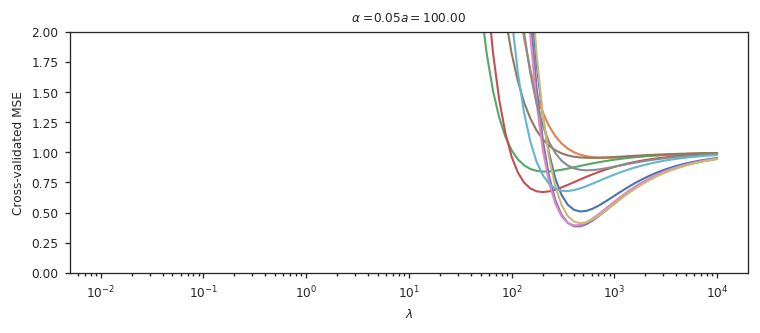

In [9]:
# ps = [50, X.shape[1]]
p = 50
alpha = 0.05
alpha = max(0.03, alpha)

plt.figure(figsize=(7,2.5))

a_huber = 100.0

print("n_features ", int(np.around((X.shape[0]-1) / alpha)))

# for subplotnum, p in enumerate(ps):
for i in range(Y.shape[1]):
    print('{:d} '.format(i),end='')
print("")

for i in range(Y.shape[1]):
    print('. ', end='')
    y = Y[:,i]

    n_features = int(np.around((X.shape[0]-1) / alpha))
    init_cond = np.random.random((X.shape[0], n_features))

    # start = time.time()
    # create a list of train_X, train_y, test_X, test_y that will be used by the function huber_leave_one_out_cv
    list_train_X = [np.delete(X, idx, axis=0)[:,:n_features] for idx in range(X.shape[0])]
    list_train_y = [np.delete(y, idx, axis=0) for idx in range(X.shape[0])]
    list_test_X = [X[idx,:n_features].reshape(1,-1) for idx in range(X.shape[0])]
    list_test_y = [y[idx] for idx in range(X.shape[0])]
    end = time.time()
    # print("{:.3f}".format(end - start))

    N = 100
    reg_params = np.logspace(-2, 4, N)
    cv_MSE = np.empty_like(reg_params)

    for idx, rp in enumerate(reg_params[::-1]):
        start = time.time()
        cv_MSE[N - 1 - idx] = huber_leave_one_out_cv(X, y.copy(), rp, alpha, a_huber, inital_conditions=init_cond)
        end = time.time()
        # print("{:d} time {:.3f}".format(idx, end - start))
        # print('{:d} {:.3f}'.format(idx, rp))

    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot(reg_params, cv_MSE, '-', color=color)

    # plt.plot(fit['lambda_min'], np.min(fit['cvm']), 'o', color=color, clip_on=False)
print('')

plt.title(r"$\alpha $ =" + "{:.2f}".format(alpha) + r" $a = $" + "{:.2f}".format(a_huber))
plt.xlabel(r'$\lambda$')
plt.ylabel('Cross-validated MSE')
# plt.title('liver.toxicity data set. $n=64$, $p=' + str(p) + '$')
plt.xscale('log')
plt.ylim([0, 2])
# plt.xlim([10**-5,10**10])
# sns.despine()
plt.show()


In [5]:
def huber_leave_one_out_cv_optimized_a(X, y, reg_param, alpha, inital_conditions=None, max_iter=10000):

    def huber_leave_one_out_cv_a_optim(a):
        return huber_leave_one_out_cv(X, y, reg_param, alpha, a, inital_conditions=inital_conditions, max_iter=max_iter)
    
    obj = optimize.minimize_scalar(
        huber_leave_one_out_cv_a_optim,
        method='brent',
        bounds=(0.01, 10.0),
        tol=1e-3,
        options={'maxiter': 200, "disp":True},
    )

    if obj.success:
        fun_min_val = obj.fun
        a_opt = obj.x

        return fun_min_val, a_opt
    else:
        raise RuntimeError('Optimization failed')


In [ ]:
# ps = [50, X.shape[1]]
p = 50
alpha = 0.5
alpha = max(0.03, alpha)

plt.figure(figsize=(7,2.5))

# for subplotnum, p in enumerate(ps):
for i in range(Y.shape[1]):
    print('{:d} '.format(i),end='')
print("")

for i in range(Y.shape[1]):
    print('. ', end='')
    y = Y[:,i]

    n_features = int(np.around((X.shape[0]-1) / alpha))
    init_cond = np.random.random((X.shape[0], n_features))

    # start = time.time()
    # create a list of train_X, train_y, test_X, test_y that will be used by the function huber_leave_one_out_cv
    list_train_X = [np.delete(X, idx, axis=0)[:,:n_features] for idx in range(X.shape[0])]
    list_train_y = [np.delete(y, idx, axis=0) for idx in range(X.shape[0])]
    list_test_X = [X[idx,:n_features].reshape(1,-1) for idx in range(X.shape[0])]
    list_test_y = [y[idx] for idx in range(X.shape[0])]
    end = time.time()
    # print("{:.3f}".format(end - start))

    N = 30
    reg_params = np.logspace(-2, 4, N)
    cv_MSE = np.empty_like(reg_params)
    a_opt = np.empty_like(reg_params)

    for idx, rp in enumerate(reg_params[::-1]):
        start = time.time()
        cv_MSE[N - 1 - idx], a_opt[N - 1 - idx] = huber_leave_one_out_cv_optimized_a(X, y.copy(), rp, alpha, inital_conditions=init_cond)
        end = time.time()
        # print("{:d} time {:.3f}".format(idx, end - start))
        # print('{:d} {:.3f}'.format(idx, rp))

    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot(reg_params, cv_MSE, '-', color=color)

    # plt.plot(fit['lambda_min'], np.min(fit['cvm']), 'o', color=color, clip_on=False)
print('')

plt.xlabel(r'$\lambda$')
plt.ylabel('Cross-validated MSE')
# plt.title('liver.toxicity data set. $n=64$, $p=' + str(p) + '$')
plt.xscale('log')
plt.ylim([0, 2])
# plt.xlim([10**-5,10**10])
# sns.despine()
plt.show()
